In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 2 # polynomial degree
e = 0.0 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 70.6975
0 -> 16 -> 9 -> 11 -> 2 -> 7 -> 18 -> 13 -> 6 -> 19 -> 1 -> 12 -> 4 -> 14 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.60it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 112.36it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.90it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.89it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 3
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=1)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

Num of cores: 1


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                            | 0/3 [00:09<?, ?it/s]

Epoch   0, Train Regret:  95.8844%, Val Regret:  98.4430%


Epoch    0, Loss:  -0.9985:  33%|██████████████████▋                                     | 1/3 [00:30<00:40, 20.13s/it]

Epoch   1, Train Regret:   4.8378%, Val Regret:   5.9520%


Epoch    1, Loss:  -0.9995:  67%|█████████████████████████████████████▎                  | 2/3 [00:50<00:20, 20.51s/it]

Epoch   2, Train Regret:   2.2987%, Val Regret:   2.7971%


Epoch    2, Loss:  -0.9998: 100%|████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.45s/it]


Epoch   2, Train Regret:   1.5843%, Val Regret:   2.4013%

Evaluation:
Test Regret: 1.9413%
Training Elapsed Time: 28.53 Sec


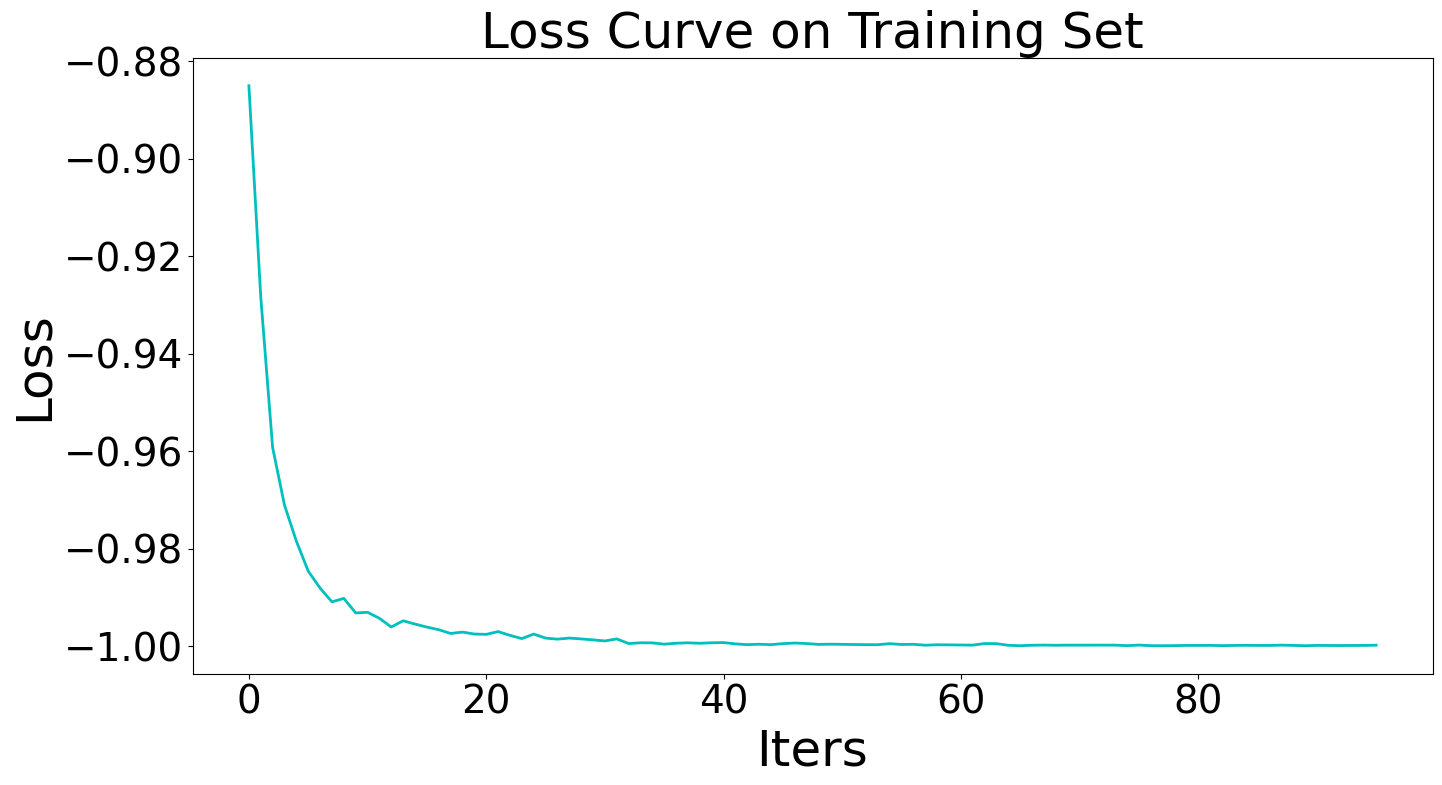

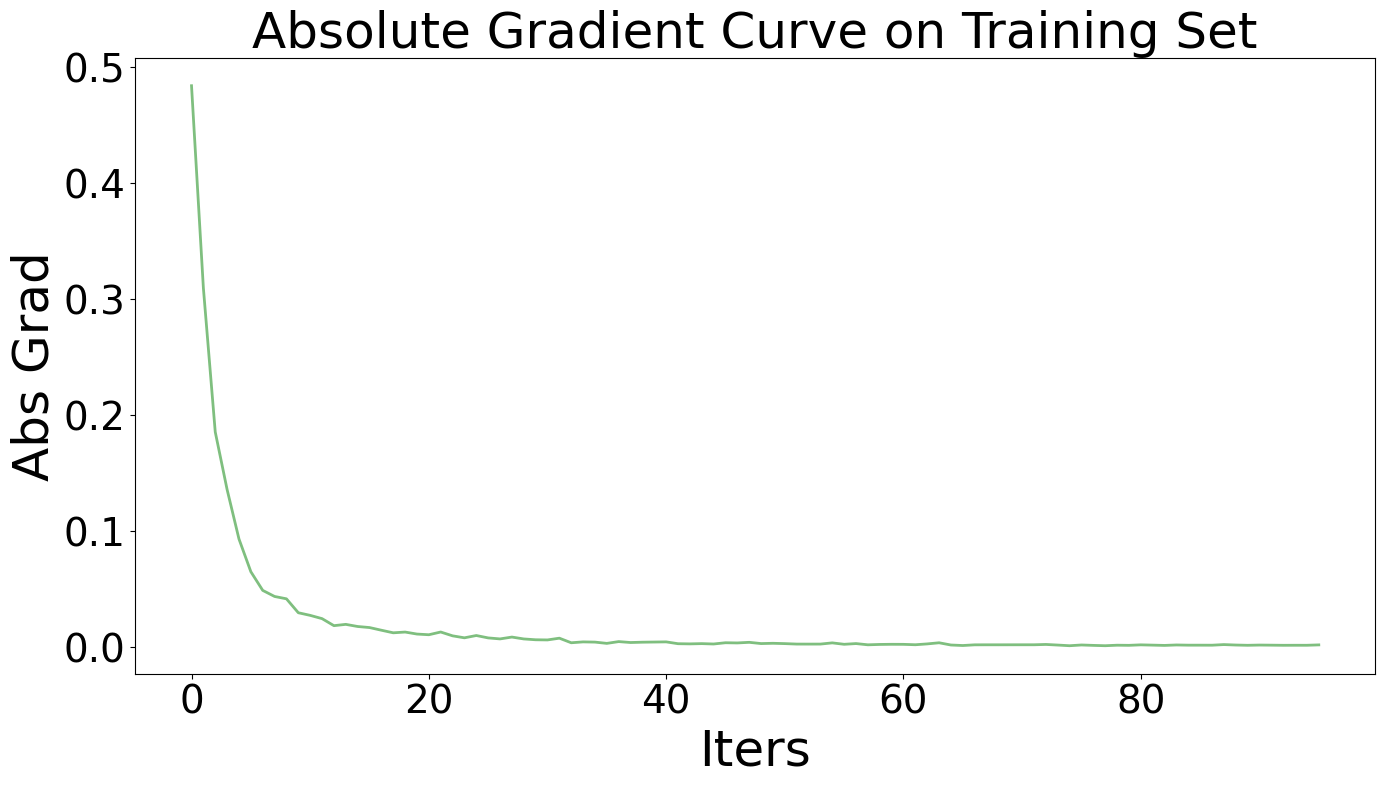

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [16]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)
# init log
grad_log = []
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", reduction="none", processes=1)
# train
for data in loader_train:
    # unzip data
    x, c, w, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(grad.detach()))
    # loss
    loss = ca_cos(cp, t_ctr)
    # backward pass
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    for i in range(batch_size):
        print("True Obj:", (c[i]@w[i]).item())
        optmodel.setObj(cp[i].cpu().detach().numpy())
        sol, obj = optmodel.solve()
        print("Pred Obj:", (c[i]@sol).item())
        print("Loss:", loss[i].item())
        print("Grad Abs Sum:", torch.abs(grad_log[-1][i]).sum().item())
        print("Grad:", grad_log[-1][i])
        print()
    break

Num of cores: 1
True Obj: 49.98040008544922
Pred Obj: 50.55909729003906
Loss: -0.999874472618103
Grad Abs Sum: 4.4540545786730945e-05
Grad: tensor([-1.7011e-08, -3.2320e-08,  3.4761e-09, -8.6075e-09, -3.2582e-08,
        -3.0013e-08, -2.9948e-08, -1.3457e-08, -2.6761e-08, -1.8284e-08,
        -1.8081e-08, -2.6841e-08, -4.0673e-08, -1.7812e-08, -4.1200e-09,
        -3.5507e-08, -1.1722e-08, -3.8330e-08, -2.7983e-08, -1.1347e-08,
        -1.1056e-08,  4.1124e-08,  1.2260e-08, -5.5261e-09, -8.2291e-09,
         1.2489e-08, -3.8672e-09, -1.6562e-09,  2.7539e-09,  1.2956e-09,
         1.6094e-08,  2.6102e-10, -4.3165e-09, -1.2569e-08, -6.8176e-09,
         3.7335e-09, -1.6021e-09, -6.1773e-09, -3.4692e-08, -9.4115e-09,
        -2.0344e-08,  4.2968e-06, -1.5210e-08, -1.8613e-09, -3.2480e-08,
         1.0063e-08, -1.0456e-08, -3.9731e-06, -3.2916e-08, -8.9094e-09,
         1.3388e-08, -2.0234e-08, -3.0503e-07, -1.4414e-08, -5.1041e-09,
         6.8540e-09, -1.2460e-09, -1.8219e-08, -5.4351e-0

Grad: tensor([-3.7890e-09, -3.2160e-09,  3.2914e-06, -3.5007e-06, -1.1205e-08,
        -5.6971e-09, -2.8249e-09,  2.2801e-09,  4.8658e-09, -9.5170e-09,
         1.1223e-09, -6.6248e-09, -4.1382e-09,  2.6039e-09,  6.2937e-09,
        -6.4028e-09,  2.4099e-07,  1.1892e-09, -1.0386e-08, -1.3402e-08,
        -3.1141e-09,  5.7589e-09,  2.4611e-09, -2.4090e-10, -6.0718e-09,
        -2.1631e-08,  1.3519e-08, -9.8498e-10,  1.7280e-09,  1.6325e-09,
         9.8189e-09, -1.0485e-08,  2.5957e-09, -1.2915e-08,  3.0703e-06,
        -4.9022e-09, -3.0505e-06, -1.6567e-08, -1.2173e-08, -1.7390e-08,
         2.1910e-09, -8.5976e-11, -9.9462e-09, -2.3165e-09, -1.4224e-08,
        -1.9449e-08, -1.5709e-08, -9.7134e-10, -1.6815e-08,  1.3753e-06,
        -1.3747e-06, -1.1925e-08,  1.2311e-08, -2.4647e-09, -1.0063e-08,
         5.7589e-09, -2.7367e-09, -8.8185e-09, -2.5848e-09, -7.2469e-09,
        -4.9131e-09, -7.7671e-09, -6.5957e-09, -8.3710e-09, -1.3817e-08,
        -1.1714e-08, -8.4910e-09, -3.2769e-06

### PFYL

In [17]:
# init model
reg = LinearRegression()

In [18]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=1)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 1


In [19]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                            | 0/3 [00:10<?, ?it/s]

Epoch   0, Train Regret:  91.9159%, Val Regret:  93.9521%


Epoch    0, Loss:  18.2500:  33%|██████████████████▋                                     | 1/3 [00:30<00:41, 20.52s/it]

Epoch   1, Train Regret:   2.4064%, Val Regret:   2.6965%


Epoch    1, Loss:  14.0000:  67%|█████████████████████████████████████▎                  | 2/3 [00:51<00:20, 20.83s/it]

Epoch   2, Train Regret:   1.2224%, Val Regret:   1.4642%


Epoch    2, Loss:  14.0000: 100%|████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.54s/it]


Epoch   2, Train Regret:   1.0209%, Val Regret:   1.2233%

Evaluation:
Test Regret: 1.2141%
Training Elapsed Time: 28.25 Sec


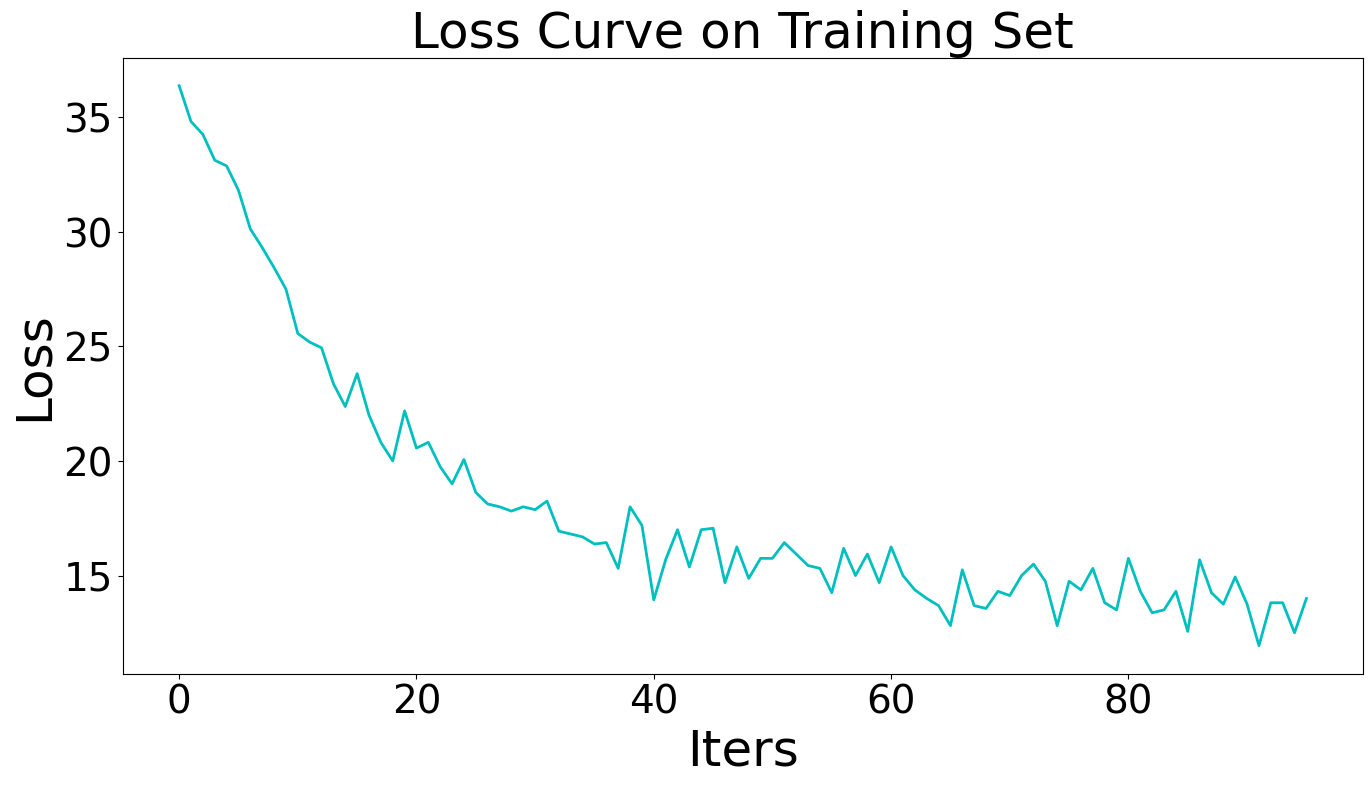

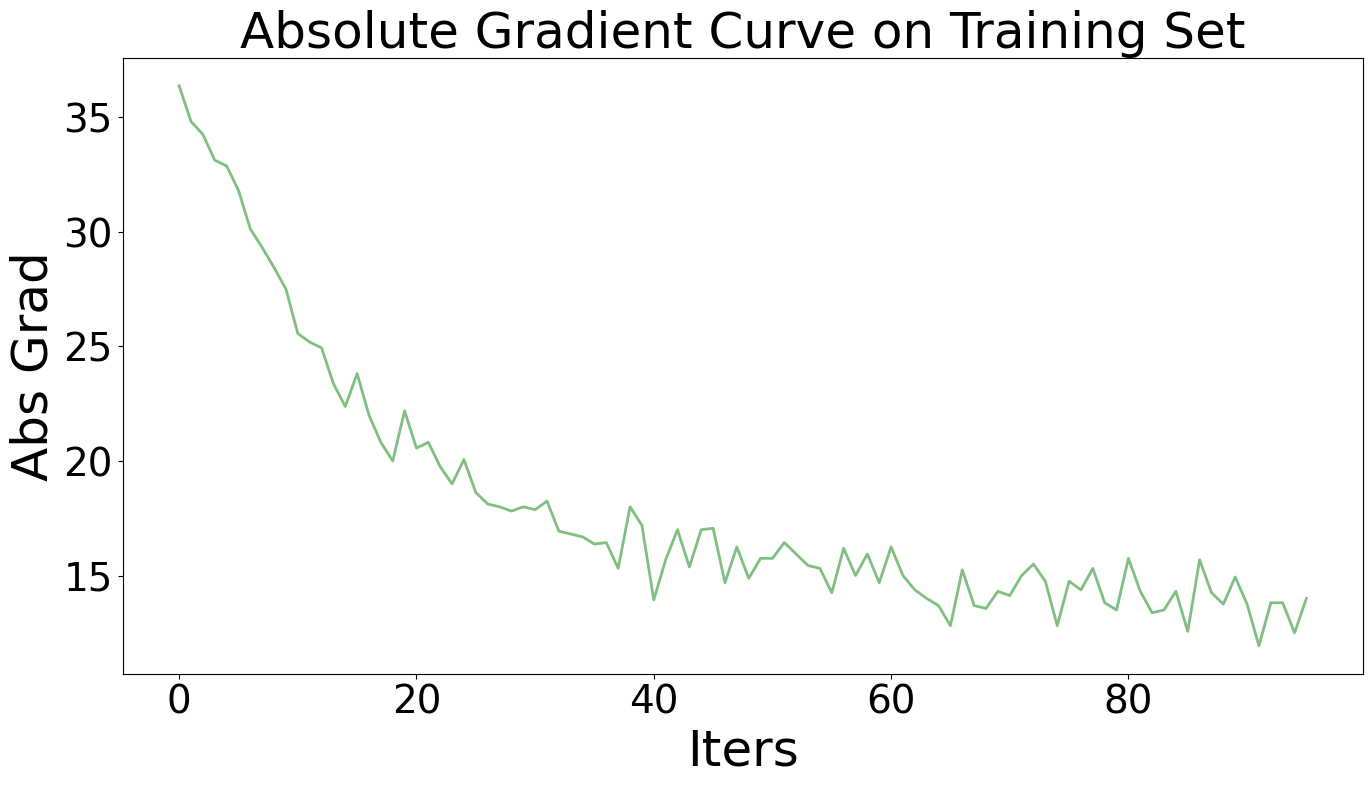

In [20]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [21]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)
# init log
grad_log = []
# train
for data in loader_train:
    # unzip data
    x, c, w, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(grad.detach()))
    # loss
    loss = pfy(cp, w, reduction="none")
    # backward pass
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    for i in range(batch_size):
        print("True Obj:", (c[i]@w[i]).item())
        optmodel.setObj(cp[i].cpu().detach().numpy())
        sol, obj = optmodel.solve()
        print("Pred Obj:", (c[i]@sol).item())
        print("Loss:", loss[i].item())
        print("Grad Abs Sum:", torch.abs(grad_log[-1][i]).sum().item())
        print("Grad:", grad_log[-1][i])
        print()
    break

True Obj: 49.98040008544922
Pred Obj: 50.102298736572266
Loss: 18.0
Grad Abs Sum: 0.5625
Grad: tensor([-0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0312,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0312,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0312,  0.0000,

Pred Obj: 60.95130157470703
Loss: 14.0
Grad Abs Sum: 0.4375
Grad: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0312,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0312,  0.0000,  0.0000, -0.0312,  0.0000,  0.0000,  0.0000, -0.0312,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -